# LSTM-VAE

This model was developed with great help from:

https://keras.io/examples/generative/vae/

https://keras.io/examples/nlp/lstm_seq2seq/

https://github.com/NicGian/text_VAE/blob/master/text_VAE_v18.ipynb

https://github.com/rstudio/keras/blob/master/vignettes/examples/lstm_seq2seq.py

https://towardsdatascience.com/character-level-cnn-with-keras-50391c3adf33

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pickle
import keras
import codecs
import csv
import os
import random

from keras.layers import Bidirectional, Dense, Embedding, Input, Lambda, LSTM, RepeatVector, TimeDistributed, Layer, Activation, Dropout, Masking
from keras.preprocessing.sequence import pad_sequences
from keras.layers.advanced_activations import ELU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras import metrics
from keras.models import Model
from scipy import spatial

## Import, clean, and encode input data

In [2]:
imported_data = pd.read_hdf("test_database.h5")
mofids = imported_data["MOFid"].tolist()
print(mofids[1])

[BiH2][BiH2].C1(=CC=C(C=C1)(C(O)=O))(C(O)=O).COc1cc((C(O)=O))c(OC)cc1(C(O)=O) MOFid-v1.bew.cat0;comment


In [3]:
def clean_inputs(mofid, cleaned_list):
    for i in range(len(mofid)):
        unclean = mofid[i]
        spaces_removed = unclean.replace(' ','')
        version_removed = spaces_removed.replace('MOFid-v1', '')
        comment_removed = version_removed.replace(';comment', '')
        clean = comment_removed.replace('.cat0', '')
        cleaned_list.append(clean)

clean_mofids = []
clean_inputs(mofids, clean_mofids)
max_mofid_length = max([len(mofid) for mofid in clean_mofids])
print(clean_mofids[1])

[BiH2][BiH2].C1(=CC=C(C=C1)(C(O)=O))(C(O)=O).COc1cc((C(O)=O))c(OC)cc1(C(O)=O).bew


In [4]:
tk = Tokenizer(num_words=300, char_level=True, lower=False, oov_token='UNK')
tk.fit_on_texts(clean_mofids)
char_index = tk.word_index
vocab_size = len(tk.word_index)
index2char = {v: k for k, v in char_index.items()}

print("Found %s unique tokens" % vocab_size)
print(char_index)

full_sequences = tk.texts_to_sequences(clean_mofids)
full_data_padded = pad_sequences(full_sequences, maxlen=max_mofid_length, padding='post')

print('Shape of data tensor:', full_data_padded.shape)

# separate off a validation set, smaller set for testing
#val_split = full_data_padded[800:1000]
#train_split = full_data_padded[:800]
val_split = full_data_padded[8500:10500]
train_split = full_data_padded[:8500]

#train_data = np.array(full_data_padded, dtype="int")
#train_split, val_split = train_test_split(train_data, test_size = 0.2, random_state = 42)

embedding_weights = []
embedding_weights.append(np.zeros(vocab_size))

for char, i in tk.word_index.items():
    onehot = np.zeros(vocab_size)
    onehot[i-1] = 1
    embedding_weights.append(onehot)
embedding_weights = np.array(embedding_weights)

print('Shape of embedding weights tensor:',embedding_weights.shape)
#print(embedding_weights)

Found 52 unique tokens
{'UNK': 1, '(': 2, ')': 3, 'O': 4, 'C': 5, 'c': 6, '=': 7, '1': 8, '[': 9, ']': 10, '.': 11, 'n': 12, 'F': 13, 'N': 14, '2': 15, '+': 16, 'l': 17, '@': 18, 'u': 19, '3': 20, 'Z': 21, '#': 22, '4': 23, '6': 24, 'q': 25, 'o': 26, 'H': 27, 'd': 28, 'P': 29, 'i': 30, 'e': 31, '-': 32, 'R': 33, 'S': 34, '5': 35, 'b': 36, 'M': 37, 'z': 38, 'h': 39, 'p': 40, 'g': 41, 'r': 42, 's': 43, 'B': 44, 't': 45, 'T': 46, 'W': 47, 'w': 48, 'j': 49, 'a': 50, 'x': 51, 'y': 52}
Shape of data tensor: (10651, 485)
Shape of embedding weights tensor: (53, 52)


A LSTM network expects the input to be in the form [samples, time steps, features] where samples is the number of data points we have, time steps is the number of time-dependent steps that are there in a single data point, features refers to the number of variables we have for the corresponding true value in Y. 

## Build the LSTM-VAE model

In [6]:
batch_size = 50
max_len = max_mofid_length
embedding_size = vocab_size
intermediate_dim = 128
latent_dim = 32
epsilon_std = 1.0
kl_weight = 0.01
#num_sampled=500

x = Input(shape=(max_len,))
x_embed = Embedding(vocab_size+1, embedding_size, mask_zero=True, input_length=max_len, weights=[embedding_weights])(x)
h = Bidirectional(LSTM(intermediate_dim, return_sequences=False, recurrent_dropout=0.2), merge_mode='concat')(x_embed)
z_mean = Dense(latent_dim, name="z_mean")(h)
z_log_var = Dense(latent_dim, name="z_log_var")(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

repeated_context = RepeatVector(max_len)
decoder_h = LSTM(vocab_size, return_sequences=True, recurrent_dropout=0.2)
decoder_mean = Dense(vocab_size+1, activation='relu')#softmax is applied in the seq2seqloss by tf
h_decoded = decoder_h(repeated_context(z))
x_decoded_mean = decoder_mean(h_decoded)

# placeholder loss
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
        self.target_weights = tf.constant(np.ones((batch_size, max_len)), tf.float32)

    def vae_loss(self, x, x_decoded_mean):
        #xent_loss = K.sum(metrics.categorical_crossentropy(x, x_decoded_mean), axis=-1)
        labels = tf.cast(x, tf.int32)
        xent_loss = K.sum(tfa.seq2seq.sequence_loss(x_decoded_mean, labels, 
                                                     weights=self.target_weights,
                                                     average_across_timesteps=False,
                                                     average_across_batch=False), axis=-1)#,
                                                     #softmax_loss_function=softmax_loss_f), axis=-1)#,
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        xent_loss = K.mean(xent_loss)
        kl_loss = K.mean(kl_loss)
        return K.mean(xent_loss + kl_weight * kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        print(x.shape, x_decoded_mean.shape)
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # we don't use this output, but it has to have the correct shape:
        return K.ones_like(x)

def kl_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    kl_loss = kl_weight * kl_loss
    return kl_loss
    
loss_layer = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, [loss_layer])
opt = Adam(lr=0.01)

vae.compile(optimizer='adam', loss=[zero_loss], metrics=[kl_loss])
vae.summary()

(None, 485) (50, 485, 53)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 485)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 485, 52)      2756        input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          185344      embedding_2[0][0]                
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 32)           8224        bidirectional_2[0][0]            
__________________________________________________________________

## Train model

In [7]:
attempt = 9

def create_model_checkpoint(dir, model_name):
    filepath = dir + '/' + model_name + ".h5" 
    directory = os.path.dirname(filepath)
    try:
        os.stat(directory)
    except:
        os.mkdir(directory)
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
    return checkpointer

checkpointer = create_model_checkpoint('models', f'lstm_vae_attempt{attempt}_best_weights')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001)

history = vae.fit(train_split, train_split,
                  shuffle=True,
                  epochs=100,
                  batch_size=batch_size,
                  validation_data=(val_split, val_split),
                  callbacks=[checkpointer, reduce_lr])

print(K.eval(vae.optimizer.lr))
#K.set_value(vae.optimizer.lr, 0.01)

vae.save(f'models/lstm_vae_attempt{attempt}.h5')

/home/adam/anaconda3/envs/ai3sd/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8500 samples, validate on 2000 samples
Epoch 1/100
8500/8500 [==============================] - 342s 40ms/step - loss: 773.2999 - kl_loss: 3.1584 - val_loss: 756.3571 - val_kl_loss: 3.7894

Epoch 00001: val_loss improved from inf to 756.35707, saving model to models/lstm_vae_attempt9_best_weights.h5
Epoch 2/100
8500/8500 [==============================] - 333s 39ms/step - loss: 538.1200 - kl_loss: 3.5892 - val_loss: 669.0266 - val_kl_loss: 3.3626

Epoch 00002: val_loss improved from 756.35707 to 669.02655, saving model to models/lstm_vae_attempt9_best_weights.h5
Epoch 3/100
8500/8500 [==============================] - 331s 39ms/step - loss: 486.6104 - kl_loss: 3.2686 - val_loss: 608.2920 - val_kl_loss: 3.3114

Epoch 00003: val_loss improved from 669.02655 to 608.29199, saving model to models/lstm_vae_attempt9_best_weights.h5
Epoch 4/100
8500/8500 [==============================] - 330s 39ms/step - loss: 468.1028 - kl_loss: 3.1319 - val_loss: 595.6232 - val_kl_loss: 3.1996

Epo

8500/8500 [==============================] - 330s 39ms/step - loss: 339.4094 - kl_loss: 1.7601 - val_loss: 492.6446 - val_kl_loss: 1.8581

Epoch 00076: val_loss did not improve from 484.16070
Epoch 77/100
8500/8500 [==============================] - 329s 39ms/step - loss: 336.7036 - kl_loss: 1.7551 - val_loss: 503.5888 - val_kl_loss: 1.8564

Epoch 00077: val_loss did not improve from 484.16070
Epoch 78/100
8500/8500 [==============================] - 330s 39ms/step - loss: 333.7515 - kl_loss: 1.7637 - val_loss: 511.7731 - val_kl_loss: 1.8700

Epoch 00078: val_loss did not improve from 484.16070
Epoch 79/100
8500/8500 [==============================] - 330s 39ms/step - loss: 332.7033 - kl_loss: 1.7722 - val_loss: 521.5990 - val_kl_loss: 1.8643

Epoch 00079: val_loss did not improve from 484.16070
Epoch 80/100
8500/8500 [==============================] - 330s 39ms/step - loss: 334.9826 - kl_loss: 1.7628 - val_loss: 498.9265 - val_kl_loss: 1.8509

Epoch 00080: val_loss did not improve fro

In [34]:
print(history.history.keys())

temp_hist = history

dict_keys(['val_loss', 'val_kl_loss', 'loss', 'kl_loss', 'lr'])


In [36]:
# save and load history to ensure it has been saved correctly

# set model to None because we have a custom layer in the model and it won't save
# correctly otherwise. This is fine because we only care about the history here.
temp_hist.model = None

pickle.dump(temp_hist, open(f'history_dict_{attempt}.p', 'wb'))
    
new_hist = pickle.load(open(f"history_dict_{attempt}.p", "rb"))
print(new_hist.history.keys())

dict_keys(['val_loss', 'val_kl_loss', 'loss', 'kl_loss', 'lr'])


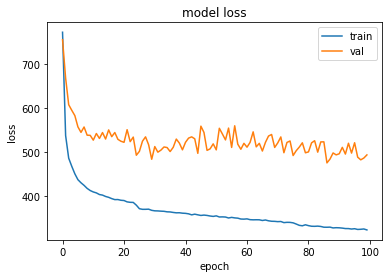

In [37]:
plt.plot(new_hist.history['loss'])
plt.plot(new_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

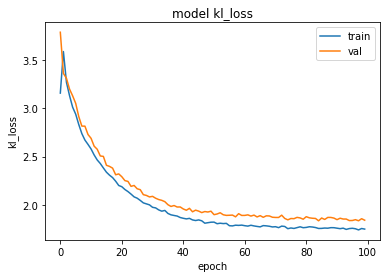

In [38]:
plt.plot(new_hist.history['kl_loss'])
plt.plot(new_hist.history['val_kl_loss'])
plt.title('model kl_loss')
plt.ylabel('kl_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

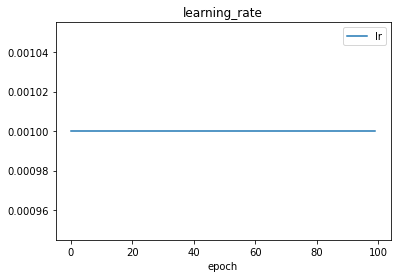

In [39]:
plt.plot(new_hist.history['lr'])
plt.title('learning_rate')
plt.xlabel('epoch')
plt.legend(['lr'], loc='upper right')
plt.show()

## Test model

In [11]:
vae.load_weights(f'models/lstm_vae_attempt{attempt}_best_weights.h5')

# build a model to project sentences on the latent space
encoder = Model(x, z_mean)
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 485)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 485, 52)           2756      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               185344    
_________________________________________________________________
z_mean (Dense)               (None, 32)                8224      
Total params: 196,324
Trainable params: 196,324
Non-trainable params: 0
_________________________________________________________________


In [12]:
# build a generator that can sample sentences from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(repeated_context(decoder_input))
_x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_mean = Activation('softmax')(_x_decoded_mean)
generator = Model(decoder_input, _x_decoded_mean)
generator.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 485, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 485, 52)           17680     
_________________________________________________________________
dense_2 (Dense)              (None, 485, 53)           2809      
_________________________________________________________________
activation_1 (Activation)    (None, 485, 53)           0         
Total params: 20,489
Trainable params: 20,489
Non-trainable params: 0
_________________________________________________________________


In [13]:
index2char = {v: k for k, v in char_index.items()}
index2char[0] = '0' # padding value

mofid_index = 2
mofid_encoded = encoder.predict(val_split[mofid_index:mofid_index+2])
x_test_reconstructed = generator.predict(mofid_encoded, batch_size = 1)
reconstructed_indexes = np.apply_along_axis(np.argmax, 1, x_test_reconstructed[0])

print(reconstructed_indexes)

generated_mofid = list(np.vectorize(index2char.get)(reconstructed_indexes))
generated_mofid = ''.join(map(str, generated_mofid))
print('Reconstructed MOFid: ', generated_mofid)

original_mofid = list(np.vectorize(index2char.get)(val_split[mofid_index]))
original_mofid = ''.join(map(str, original_mofid))
print('Original MOFid: ', original_mofid)

[ 9 21 12 10  2  7  3  3  9  3  4  7  7  7  7  7  7  7  7  5  5  5  5  5
  5  5  5  5  5  5  5  5  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3 13  6  6  6  6  2  2  2  2  2  3  3  3  3  3  3  3  3  3  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  4  4  4  4  4  4  4  4  2  2  2  6  6  6  6  2  2
  2  2  4  4  4  4  3  3 25 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0